In [1]:
import init_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lorenz import solve_lorenz, plot_lorenz
from time_delay import delay_series
from scipy.spatial.distance import cdist
from scipy.integrate import odeint

# Part I

In [2]:
takens_df = pd.read_csv("task_4/takens_1.txt", sep=" ", names=["x0", "x1"])
takens_df.head()

,x0,x1
0,2.168371,-0.546313
1,2.179811,-0.532475
2,2.190028,-0.518940
3,2.198638,-0.506198
4,2.205623,-0.494355


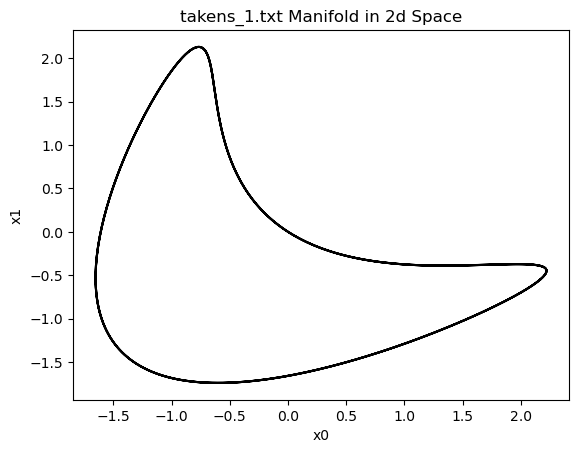

In [3]:
takens_df.plot(x="x0", y="x1", title="takens_1.txt Manifold in 2d Space", xlabel="x0", ylabel="x1", legend=False, color="black");

## Plot the first coordinate against the line number in the dataset (the “time”)

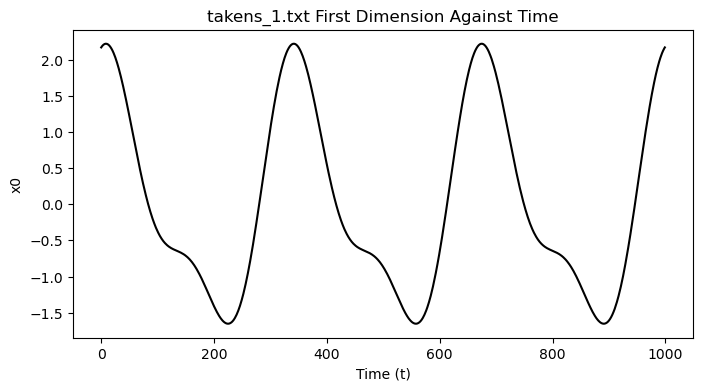

In [4]:
takens_df.x0.plot(title="takens_1.txt First Dimension Against Time", xlabel="Time (t)", ylabel="x0", color="black", figsize=(8,4));

## Plot the coordinate against its delayed version

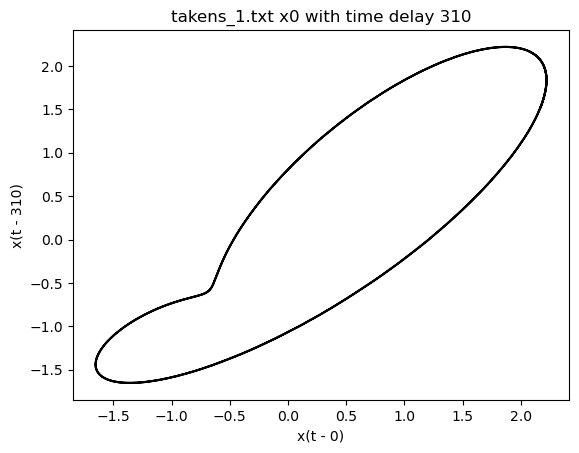

In [5]:
delay = 310
delayed_df = delay_series(takens_df.x0, delay, 2)
delayed_df.plot(x=delayed_df.columns[0], y=delayed_df.columns[1], legend=False, title=f"takens_1.txt x0 with time delay {delay}", xlabel=delayed_df.columns[0], ylabel=delayed_df.columns[1], color="black");

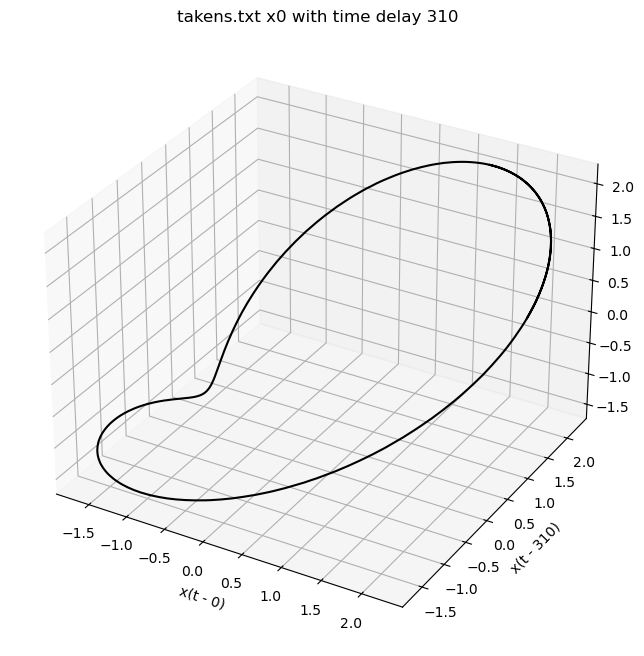

In [6]:
delay = 310
delayed_df = delay_series(takens_df.x0, delay, 3)
X, Y, Z = delayed_df.iloc[:, 0], delayed_df.iloc[:, 1], delayed_df.iloc[:, 2]

fig = plt.figure(figsize=(16, 8))
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
ax0.plot(X, Y, Z, color="black");
plt.title(f"takens.txt x0 with time delay {delay}")
plt.xlabel(delayed_df.columns[0])
plt.ylabel(delayed_df.columns[1])
plt.show()

# Part II

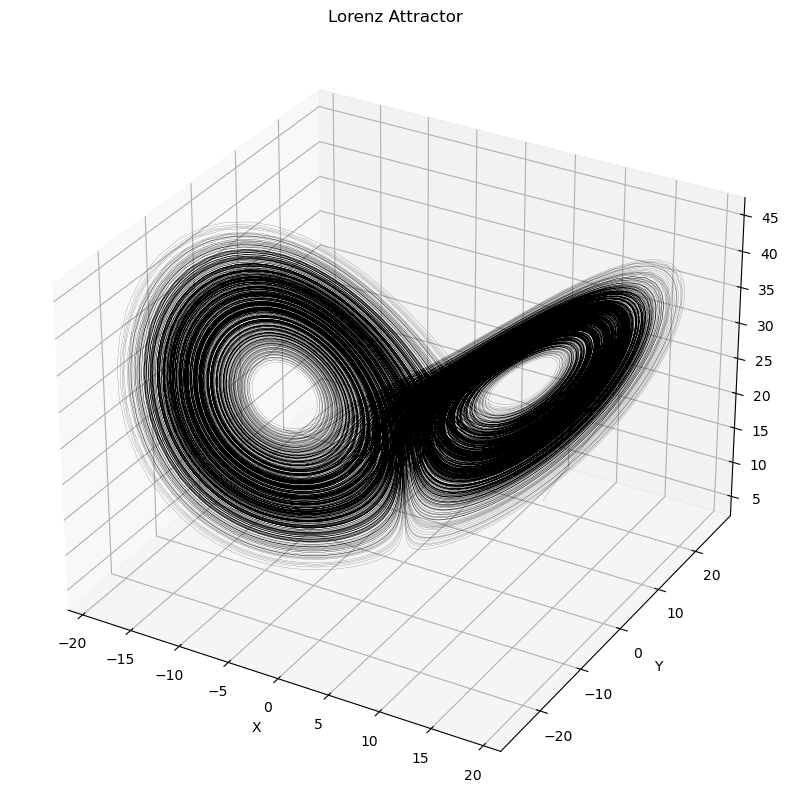

In [7]:
t = np.arange(0.0, 1000, 0.01)
lorenz_traj = solve_lorenz( p0=[10, 10, 10],t=t, sigma=10, beta=8 / 3, rho=28);
plot_lorenz(lorenz_traj, "Lorenz Attractor", "X", "Y", "Z")

## Visualize x1 = x(t) against x2 = x(t + ∆t) and x3 = x(t + 2∆t) in a three-dimensional plot

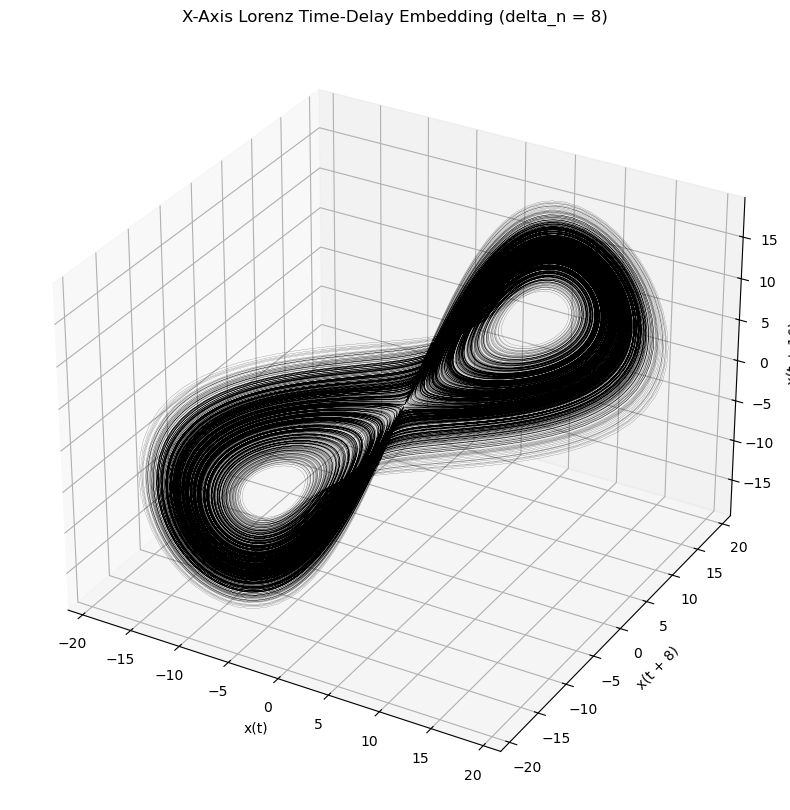

In [8]:
delayed_lorenz_x = delay_series(lorenz_traj.x, delta_n=8, m=3)
plot_lorenz(delayed_lorenz_x, "X-Axis Lorenz Time-Delay Embedding (delta_n = 8)", "x(t)", "x(t + 8)", "x(t + 16)")

## Do the same for the z coordinate

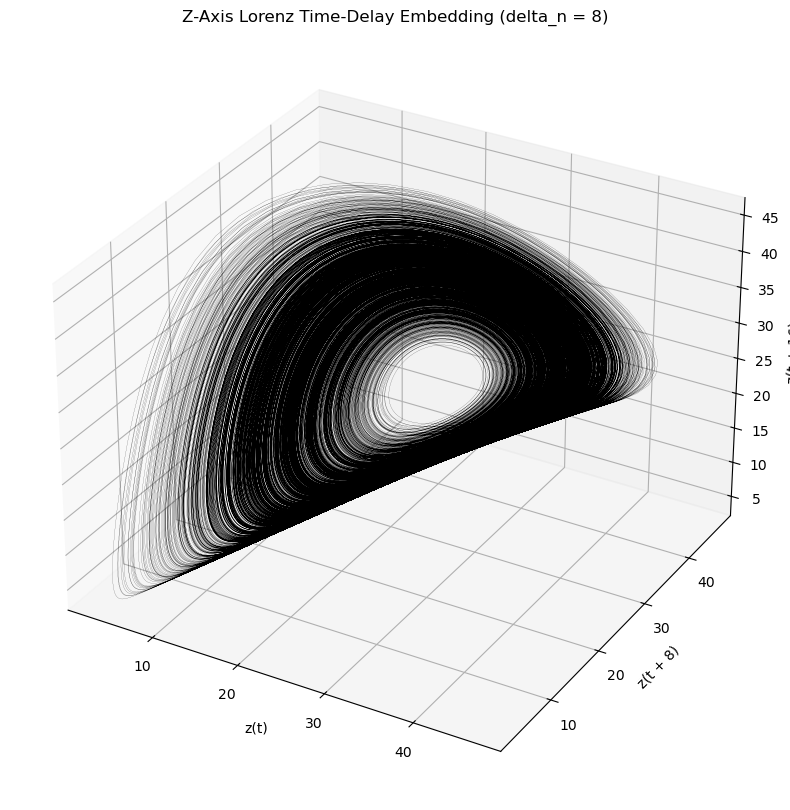

In [9]:
delayed_lorenz_z = delay_series(lorenz_traj.z, delta_n=8, m=3)
plot_lorenz(delayed_lorenz_z, "Z-Axis Lorenz Time-Delay Embedding (delta_n = 8)", "z(t)", "z(t + 8)", "z(t + 16)")

# Bonus

In [10]:
def make_dataset(embeddings, dt):
    """
    get the vector field labels given embeddings and delta t.
    """
    V = (embeddings[1:].reset_index(drop=True) - embeddings)[:-1] / dt
    X = embeddings[:-1]
    return X, V

def gaussian_rbf(X, x_l, eps):
    """
    Calculate the rafius and the gaussian rbf given 2 sets of points and the epsilon.
    """
    r = cdist(X,x_l, metric="euclidean")
    return np.exp(-r / eps**2)

class RBFInterpolation:
    def __init__(self, X, L, dt, epsilon) -> None:
        """
        Initialization for the RBF interpolation code.
        """
        random_indices = np.random.choice(X.shape[0], L + 1, replace=False)
        X_l = X.iloc[random_indices,:].reset_index(drop=True)
        self.X_l, self.V_l = make_dataset(X_l, dt)
        self.epsilon = epsilon
        Xl_phi = gaussian_rbf(self.X_l,self.X_l, self.epsilon)
        self.C_hat_transpose = np.linalg.solve(Xl_phi, self.V_l)

    def __call__(self, state, t):
        """
        Simulates the vector field in any particular step of a dynamical system.
        """
        p = np.array(state).reshape(1, -1)
        X_phi = gaussian_rbf(p,self.X_l, self.epsilon)

        return np.dot(X_phi, self.C_hat_transpose)[0]

In [11]:
t = np.arange(0.0, 1000, 0.01)
lorenz_traj = solve_lorenz( p0=[10, 10, 10],t=t, sigma=10, beta=8 / 3, rho=28);
delayed_lorenz_x = delay_series(lorenz_traj.x, delta_n=8, m=3)

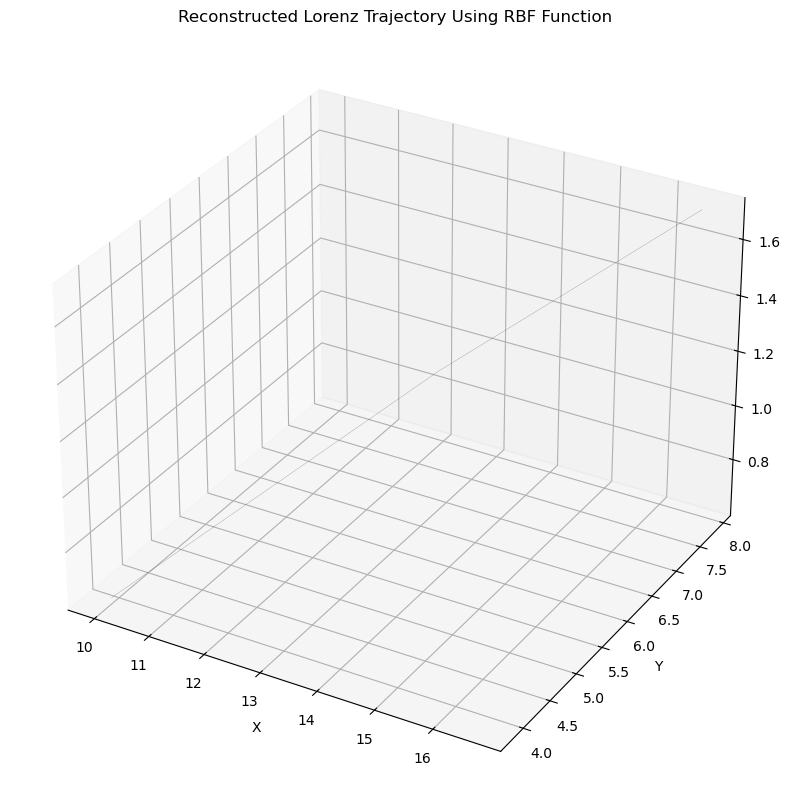

In [16]:
interp = RBFInterpolation(delayed_lorenz_x, L=4000, dt=0.01, epsilon=50)
delayed_lorenz_x_0 = list(delayed_lorenz_x.iloc[0])
result = odeint(interp, delayed_lorenz_x_0, t)
res_df = pd.DataFrame({"x":result[0],"y":result[1], "z":result[2]})
plot_lorenz(res_df,"Reconstructed Lorenz Trajectory Using RBF Function","X","Y","Z")